## Dataset

In [5]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
os.chdir(r'C:\Users\NILS\Documents\ATIAM\PAM\deep-eurorack-control\src')
from deep_eurorack_control.pipelines.ddsp.dataset_process import preprocess_dataset


In [7]:
raw_data_dir = r'C:\Users\NILS\Documents\ATIAM\PAM\Datasets\nsynth-train\audio'
dataset_dir = r'C:\Users\NILS\Documents\ATIAM\PAM\Datasets\strings'
filters = ['string_acoustic']
sr = 16000
frame_size = 256
nb_files = 3000

In [4]:
# preprocess_dataset(raw_data_dir,dataset_dir,filters,sr,frame_size,nb_files)


heeloooooo 10577


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [40:29<00:00,  1.23it/s]


In [45]:
from deep_eurorack_control.models.ddsp.decoder import Decoder
from torch.utils.data import DataLoader
from deep_eurorack_control.datasets.ddsp import  NSynth_ddsp
from deep_eurorack_control.models.ddsp.ops import *

dataset = NSynth_ddsp(dataset_dir)
data_loader = DataLoader(dataset, batch_size=4, shuffle=False)
mini_batch = next(iter(data_loader))
decoder = Decoder(101,65,n_hidden=512)




In [47]:
pitch = mini_batch[0]
loud = mini_batch[1]

harmonics,filters = decoder(pitch,loud)
signal_out = generate_signal(pitch,harmonics,filters,frame_size,sr)

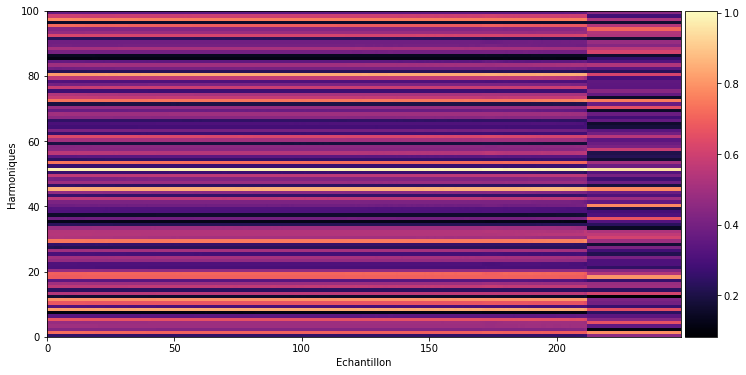

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import librosa
plot_harmonics(harmonics.detach()[0])

In [48]:
filters.shape

torch.Size([4, 250, 65])

In [37]:
def plot_harmonics(harmonics,ax=None,fig=None):
    def add_colorbar(fig, ax, im):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax, orientation="vertical")

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    harms = np.arange(harmonics.shape[1])
    times = np.arange(harmonics.shape[0])
    X, Y = np.meshgrid(times, harms)

    im0 = ax.pcolor(X, Y, harmonics.T, cmap="magma")

    add_colorbar(fig, ax, im0)
    labelRow = "Echantillon"
    labelCol = "Harmoniques"
    ax.set_xlabel(labelRow)
    ax.set_ylabel(labelCol)

In [274]:
amps = harmonics[:,:,1:]
level = harmonics[:,:,:1]
amps = level * amps/torch.sum(amps,axis=-1,keepdim=True)
amps = upsample(amps,len_signal)
f0  =  upsample(pitch,len_signal)


In [287]:
import numpy as np
freqs = f0 * torch.arange(1,amps.shape[-1]+1)[None,None,:]
phases = 2*np.pi*freqs/sr * torch.arange(0,amps.shape[1])[None,:,None]
wave = amps*torch.sin(phases)
signal = torch.sum(wave,axis=-1)

In [286]:
amps=torch.ones_like(amps)
# harmonics

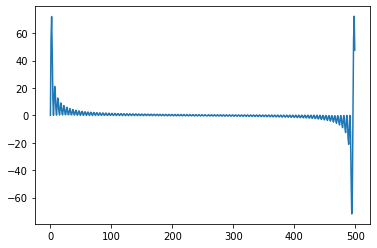

In [290]:
plt.plot(signal[0,:500])

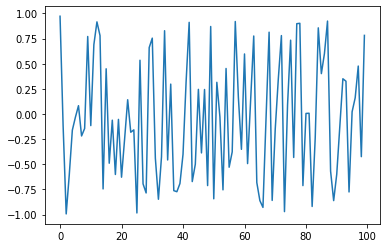

In [299]:
plt.plot(2*torch.rand(100)-1)


# Ops

## Synths


In [31]:
from deep_eurorack_control.models.ddsp.ops import  h_synth,noise_synth
import torch
nb_frames = 250
frame_size = 256
nbands=65

net_output = torch.ones(10,int(sr*4),20)
f0 = 300*torch.ones(10,int(sr*4),1)


H = torch.cat([torch.zeros(int(nbands/2)+1),torch.ones(int(nbands/2))])
H = H.repeat(10,1)
H=torch.unsqueeze(H,1)
H = H.repeat(1,nb_frames,1)

In [241]:
amps = net_output[:,:,1:]
level = net_output[:,:,:1]
amps = level * amps/torch.sum(amps,axis=-1,keepdim=True)

In [33]:
signal = h_synth(f0,amps,sr)
noise_out = noise_synth(H,frame_size)

## Loss

In [79]:
from deep_eurorack_control.models.ddsp.ops import  spectral_loss

In [102]:
signals_in = signal
signals_out = signal + torch.arange(0,10)[:,None]
alpha= 1

scales = [2048,1024,512,256,128,64]
L1 = spectral_loss(scales,signals_in,signals_out,alpha=1)

## Upsample

In [122]:
upsample(pitch,64000).shape

torch.Size([4, 64000, 1])

In [212]:
from deep_eurorack_control.models.ddsp.model import  DDSP

# Network

In [130]:

import torch.nn as nn 

In [188]:
len_signal = 64000
frame_size = 256

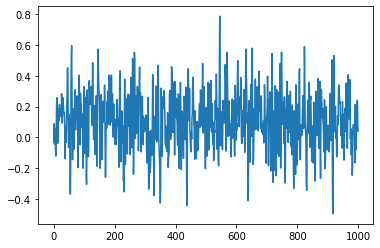

In [201]:
decoder = Decoder(101,65)

harmonics,filters = decoder(pitch.float(),loud.float())
signal = generate_signal(harmonics,filters,frame_size,len_signal)
plt.plot(signal.detach()[0][:1000])

In [199]:
decoder.parameters

<bound method Module.parameters of Decoder(
  (mlp_pitch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
  )
  (mlp_loud): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2)

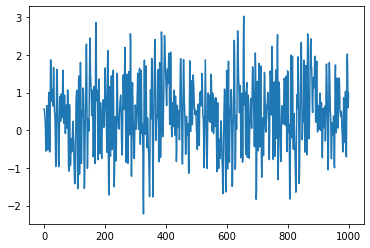

# Utils

In [79]:
sd.play(signal,sr)

In [17]:
def plot_spectrogram_mag(STFT_amp, fig=None, ax=None):
    """
    TODO: TO COMPLETE

    Parameters
    ----------
    STFT_amp
    fig
    ax

    Returns
    -------

    """

    def add_colorbar(fig, ax, im):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    times = np.linspace(0, 2 * 128 / 121, STFT_amp.shape[1])
    freqs = librosa.mel_frequencies(
        n_mels=STFT_amp.shape[0], fmin=0.0, fmax=16000 / 2, htk=True
    )

    X, Y = np.meshgrid(times, freqs)

    im0 = ax.pcolor(X, Y, STFT_amp, cmap="magma")

    add_colorbar(fig, ax, im0)
    labelRow = "Temps"
    labelCol = "Fréquences"
    ax.set_xlabel(labelRow)
    ax.set_ylabel(labelCol)

    # plt.show()


In [221]:
def save_pickle(data_dict, filepath):
    """
    Save data to pickle file

    Parameters
    ----------
    data_dict : dict
        data to save
    filepath : str
        absolute path to the file

    Returns
    -------
        None
    """
    with open(filepath, "wb") as handle:
        pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filepath):
    """
    Load data from pickle file

    Parameters
    ----------
    filepath : str
        absolute path to the file

    Returns
    -------
        data stored in the pickle file
    """
    with open(filepath, "rb") as handle:
        data = pickle.load(handle)
    return data